In [1]:
import tqdm
import glob
import torch

import pandas as pd
import numpy as np
import xarray as xr
import multiprocessing as mp
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

import torchvision.models as models
from torch import nn

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True
    

In [3]:
model_loc = "/glade/work/schreck/repos/HOLO/holodec-ml/holodecml/reader/models/resnet18_single/data/"


In [4]:
def load_sparse_csr(filename):
    # here we need to add .npz extension manually
    loader = np.load(filename + '.npz')
    return csr_matrix((loader['data'], loader['indices'], loader['indptr']),
                      shape=loader['shape'])

In [5]:
def process_one_plane(z_idx):
    
    x, y, z = [], [], []
    xt, yt, zt = [], [], []
    
    true_arr = np.zeros((sx, sy))
    pred_arr = np.zeros((sx, sy))
    
    pred_prob = load_sparse_csr(f"{model_loc}/data/prob_{h_idx}_{z_idx}")
    pred_label = load_sparse_csr(f"{model_loc}/data/pred_{h_idx}_{z_idx}")
    true_label = load_sparse_csr(f"{model_loc}/data/true_{h_idx}_{z_idx}")
    
    for ((row_idx, col_idx), (row_slice, col_slice)) in prop.idx2slice.items():
        
        max_label = np.amax(pred_label[row_slice, col_slice])
        max_probs = np.amax(pred_prob[row_slice, col_slice])
        max_truth = np.amax(true_label[row_slice, col_slice])

        true_arr[row_idx, col_idx] = max_truth
        pred_arr[row_idx, col_idx] = max_label

        if max_label == 1.0:
            x.append(row_idx)
            y.append(col_idx)
            z.append(z_idx)

        if max_truth == 1.0:
            xt.append(row_idx)
            yt.append(col_idx)
            zt.append(z_idx)
        
    
#     for row_idx in range(sx):

#         if row_idx*step_size+tile_size > true_label.shape[0]:
#             image_pixel_x = true_label.shape[0]-tile_size
#             row_slice = slice(-tile_size,None)
#             row_break = True
#         else:
#             image_pixel_x = row_idx*step_size
#             row_slice = slice(row_idx*step_size,row_idx*step_size+tile_size)
#             row_break = False

#         for col_idx in range(sy):

#             if col_idx*step_size+tile_size > true_label.shape[1]:
#                 image_pixel_y = true_label.shape[1]-tile_size
#                 col_slice = slice(-tile_size,None)
#                 col_break = True
#             else:
#                 image_pixel_y = col_idx*step_size
#                 col_slice = slice(col_idx*step_size,col_idx*step_size+tile_size)
#                 col_break = False

#             max_label = np.amax(pred_label[row_slice, col_slice])
#             max_probs = np.amax(pred_prob[row_slice, col_slice])
#             max_truth = np.amax(true_label[row_slice, col_slice])
            
#             true_arr[row_idx, col_idx] = max_truth
#             pred_arr[row_idx, col_idx] = max_label
            
#             dice_tile = dice_coef2(
#                 true_label[row_slice, col_slice].ravel(),
#                 pred_label[row_slice, col_slice].ravel()
#             )
#             dice.append(dice_tile)
            
#             if max_label == 1.0:
#                 x.append(row_idx)
#                 y.append(col_idx)
#                 z.append(z_idx)
            
#             if max_truth == 1.0:
#                 xt.append(row_idx)
#                 yt.append(col_idx)
#                 zt.append(z_idx)

#             if col_break: 
#                 break

#         if row_break:
#             break
            

    results = {
        "preds": [x, y, z],
        "truths": [xt, yt, zt],
        "metrics": []
    }
    
    return results


In [6]:
z_file_indices = sorted([int(x.replace(".npz", "").split("_")[-1]) for x in glob.glob(f"{model_loc}/true_*")])
z_file_indices

[14072,
 14216,
 14360,
 14504,
 14648,
 14792,
 14936,
 15080,
 15224,
 15368,
 15512,
 15656,
 15800,
 15944,
 16088,
 16232,
 16376,
 16520,
 16664,
 16808,
 16952,
 17096,
 17240,
 17384,
 17528,
 17672,
 17816,
 17960,
 18104,
 18248,
 18392,
 18536,
 18680,
 18824,
 18968,
 19112,
 19256,
 19400,
 19544,
 19688,
 19832,
 19976,
 20120,
 20264,
 20408,
 20552,
 20696,
 20840,
 20984,
 21128,
 21272,
 21416,
 21560,
 21704,
 21848,
 21992,
 22136,
 22280,
 22424,
 22568,
 22712,
 22856,
 23000,
 23144,
 23288,
 23432,
 23576,
 23720,
 23864,
 24008,
 24152,
 24296,
 24440,
 24584,
 24728,
 24872,
 25016,
 25160,
 25304,
 25448,
 25592,
 25736,
 25879,
 26023,
 26168,
 26312,
 26455,
 26599,
 26744,
 26888,
 27031,
 27175,
 27320,
 27464,
 27607,
 27751,
 27896,
 28040,
 28183,
 28327,
 28472,
 28616,
 28760,
 28904,
 29048,
 29192,
 29336,
 29480,
 29624,
 29768,
 29912,
 30055,
 30200,
 30344,
 30488,
 30631,
 30776,
 30920,
 31064,
 31207,
 31352,
 31496,
 31640,
 31783,
 31928,


In [7]:
max(z_file_indices)

157928

In [8]:
min(z_file_indices)

14072

In [9]:
class ResNet(nn.Module):
    def __init__(self, fcl_layers = [], dr = 0.0, output_size = 1, resnet_model = 18, pretrained = True):
        super(ResNet, self).__init__()
        self.pretrained = pretrained
        self.resnet_model = resnet_model 
        if self.resnet_model == 18:
            resnet = models.resnet18(pretrained=self.pretrained)
        elif self.resnet_model == 34:
            resnet = models.resnet34(pretrained=self.pretrained)
        elif self.resnet_model == 50:
            resnet = models.resnet50(pretrained=self.pretrained)
        elif self.resnet_model == 101:
            resnet = models.resnet101(pretrained=self.pretrained)
        elif self.resnet_model == 152:
            resnet = models.resnet152(pretrained=self.pretrained)
        resnet.conv1 = torch.nn.Conv1d(2, 64, (7, 7), (2, 2), (3, 3), bias=False) # Manually change color dim to match our data
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_output_dim = resnet.fc.in_features
        self.resnet = nn.Sequential(*modules)
        self.fcn = self.make_fcn(self.resnet_output_dim, output_size, fcl_layers, dr)
        
    def make_fcn(self, input_size, output_size, fcl_layers, dr):
        if len(fcl_layers) > 0:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, fcl_layers[0]),
                nn.BatchNorm1d(fcl_layers[0]),
                torch.nn.LeakyReLU()
            ]
            if len(fcl_layers) == 1:
                fcn.append(nn.Linear(fcl_layers[0], output_size))
            else:
                for i in range(len(fcl_layers)-1):
                    fcn += [
                        nn.Linear(fcl_layers[i], fcl_layers[i+1]),
                        nn.BatchNorm1d(fcl_layers[i+1]),
                        torch.nn.LeakyReLU(),
                        nn.Dropout(dr)
                    ]
                fcn.append(nn.Linear(fcl_layers[i+1], output_size))
        else:
            fcn = [
                nn.Dropout(dr),
                nn.Linear(input_size, output_size)
            ]
        if output_size > 1:
            fcn.append(torch.nn.LogSoftmax(dim=1))
        return nn.Sequential(*fcn)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fcn(x)
        return x

In [10]:
class InferencePropagator:
    
    def __init__(self, 
                 data_path,
                 n_bins = 1000, 
                 tile_size = 512, 
                 step_size = 128, 
                 marker_size = 10, 
                 model = None,
                 device = "cuda"):
        
        self.h_ds = xr.open_dataset(data_path)
        self.n_bins = n_bins
        self.z_bins = np.linspace(self.h_ds.attrs['zMin'],self.h_ds.attrs['zMax'], n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5*np.diff(self.z_bins)  # histogram bin centers

        self.tile_size = tile_size  # size of tiled images in pixels
        self.step_size = step_size  # amount that we shift the tile to make a new tile
        self.marker_size = marker_size # UNET gaussian marker width (standard deviation) in um
        self.device = device

        # step_size is not allowed be be larger than the tile_size
        assert self.tile_size >= self.step_size

        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx']) # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny']) # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda'] # wavelength
        self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
        self.zMax = self.h_ds.attrs['zMax'] 
        self.image_norm = 255.0

        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy
        
        self.tile_x_bins = np.arange(-self.Nx//2,self.Nx//2,self.step_size)*self.dx*1e6
        self.tile_y_bins = np.arange(-self.Ny//2,self.Ny//2,self.step_size)*self.dy*1e6
        
        self.fx = None
        self.fy = None
        self.model = model
        self.model.eval()
        
        self.create_mapping()

    
    def compute_f(self):
        self.fx = torch.fft.fftfreq(self.Nx,self.dx,device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(self.Ny,self.dy,device=self.device).unsqueeze(0).unsqueeze(1)
        
    
    def torch_holo_set(self, 
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """
        if self.fx is None:
            self.compute_f()
        
        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam*torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)

        return Eout
    

    def create_mapping(self):
        self.idx2slice = {}
        for row_idx in range(self.Nx//self.step_size):

            if row_idx*self.step_size+self.tile_size > self.Nx:
                image_pixel_x = self.Nx-self.tile_size
                row_slice = slice(-self.tile_size,None)
                row_break = True
            else:
                image_pixel_x = row_idx*self.step_size
                row_slice = slice(row_idx*self.step_size,row_idx*self.step_size+self.tile_size)
                row_break = False

            for col_idx in range(self.Ny//self.step_size):

                if col_idx*self.step_size+self.tile_size > self.Ny:
                    image_pixel_y = self.Ny-self.tile_size
                    col_slice = slice(-self.tile_size,None)
                    col_break = True
                else:
                    image_pixel_y = col_idx*self.step_size
                    col_slice = slice(col_idx*self.step_size,col_idx*self.step_size+self.tile_size)
                    col_break = False
                    
                self.idx2slice[row_idx, col_idx] = (row_slice, col_slice) 

                if col_break: 
                    break

            if row_break:
                break
        

    def get_sub_images_labeled(self,
                               image_tnsr, 
                               z_sub_set, 
                               z_counter, 
                               xp, yp, zp, dp, 
                               infocus_mask, 
                               z_part_bin_idx, 
                               batch_size = 32, 
                               thresholds = None, 
                               obs_threshold = None):
        """
        Reconstruct z_sub_set planes from
        the original hologram image and
        split it into tiles of size
        tile_size

        image - 3D tensor on device to reconstruct
        z_sub_set - array of z planes to reconstruct in one batch
        z_counter - counter of how many z images have been reconstructed

        Returns 
            Esub - a list of complex tiled images 
            image_index_lst - tile index of the sub image (x,y,z)
            image_corner_coords - x,y coordinates of the tile corner (starting values)
            z_pos - the z position of the plane in m
        """
        
        with torch.no_grad():
    
            # build the torch tensor for reconstruction
            z_plane = torch.tensor(z_sub_set*1e-6,device=self.device).unsqueeze(-1).unsqueeze(-1)

            # reconstruct the selected planes
            E_out = self.torch_holo_set(image_tnsr,z_plane)

            image = torch.abs(E_out).unsqueeze(1)
            phase = torch.angle(E_out).unsqueeze(1)
            stacked_image = torch.cat([
                torch.abs(E_out).unsqueeze(1), torch.angle(E_out).unsqueeze(1)], 1)

            size = (E_out.shape[1], E_out.shape[2])
            true_label = torch.zeros(size).to(device)
            pred_label = torch.zeros(size).to(device)
            pred_proba = torch.zeros(size).to(device)
            counter = torch.zeros(size).to(device)

            results_dict = defaultdict(list)

            for z_idx in range(E_out.shape[0]):
                
                chunked = np.array_split(
                    list(self.idx2slice.items()),
                    int(np.ceil(len(self.idx2slice) / batch_size))
                )
                
                input_x = stacked_image[z_idx, :].float()
                true_y = infocus_mask[:, :, z_idx+z_counter]
                 
                worker = partial(
                    self.collate, 
                    image = input_x, 
                    label = true_y
                )
                                    
                for chunk in chunked:
                    
                    slices, x, true_labels = worker(chunk)
                    #x = x.to(device)
                    true_labels = true_labels.to(device)
                    pred_logits = self.model(x)
                    
                    pred_probs, pred_labels = torch.max(pred_logits, 1)
                    pred_probs = pred_probs.exp()
                    pred_labels = pred_labels.squeeze(-1)
                    
                    pred_cond = pred_labels == 0
                    pred_probs = torch.where(pred_cond, 1.0 - pred_probs, pred_probs)

                    results_dict["acc"] += true_labels == pred_labels

                    for k, ((row_idx, col_idx), (row_slice, col_slice)) in enumerate(slices):
                        counter[row_slice, col_slice] += 1
                        true_label[row_slice, col_slice] += true_labels[k]
                        pred_label[row_slice, col_slice] += pred_labels[k]
                        pred_proba[row_slice, col_slice] += pred_probs[k]
                        
                        
            pred_label = pred_label / counter
            pred_proba = pred_proba / counter
            true_label = true_label / counter        
            ave_acc = [x.detach().cpu().numpy()[0] for x in results_dict["acc"]]

            pred_label = pred_label == 1.0
            true_label = true_label == 1.0
            
            pred_label = pred_label.cpu().numpy()
            pred_proba = pred_proba.cpu().numpy()
            true_label = true_label.cpu().numpy()
            
            roc = DistributedROC(thresholds=thresholds, obs_threshold=obs_threshold)
            roc.update(pred_proba.ravel(), true_label.ravel())
            
            return_dict = {
                "pred_label": pred_label,
                "pred_proba": pred_proba,
                "true_label": true_label,
                #"counter": counter,
                "acc": np.mean(ave_acc),
                "z_plane": z_sub_set[z_idx],
                "roc": roc
            }
                    
        return return_dict
    
    def collate(self, batch, image = None, label = None):
        x, y = zip(*[
            (image[:, row_slice, col_slice], 
            torch.LongTensor([int(label[row_idx, col_idx])]))
            for ((row_idx, col_idx), (row_slice, col_slice)) in batch
        ])
        x = torch.stack(x)
        y = torch.stack(y)
        return batch, x, y

            
    def get_next_z_planes_labeled(self, 
                                  h_idx, 
                                  z_planes_lst, 
                                  batch_size = 32,
                                  thresholds = np.arange(0.0, 1.1, 0.1),
                                  obs_threshold = 1.0):
        """
        Generator that returns reconstructed z patches
        input_image - 2D image array of the original captured hologam 
        z_planes_lst - list containing batchs of arrays of z positions to reconstruct
            create_z_plane_lst() will provide this for a desired batch size and set
            planes

        returns:
            sub_image - list of sub images
            image_index_lst - list of tile indicies to the sub image
            image_coords - x,y corner coordinates of the sub images
            image_z - z location of the sub image in m
        """

        # locate particle information corresponding to this hologram
        particle_idx = np.where(self.h_ds['hid'].values==h_idx+1)

        x_part = self.h_ds['x'].values[particle_idx]
        y_part = self.h_ds['y'].values[particle_idx]
        z_part = self.h_ds['z'].values[particle_idx]
        d_part = self.h_ds['d'].values[particle_idx]  # not used but here it is

        # create a 3D histogram 
        in_data = np.stack((x_part, y_part, z_part)).T
        h_part = np.histogramdd(in_data,bins=[self.tile_x_bins,self.tile_y_bins,self.z_bins])[0]
        z_part_bin_idx = np.digitize(z_part, self.z_bins)-1 # specify the z bin locations of the particles

        # smoothing kernel accounts for overlapping subimages when the 
        # subimage is larger than the stride
        if self.step_size < self.tile_size:
            overlap_kernel = np.ones((
                self.tile_size//self.step_size,self.tile_size//self.step_size
            ))
            for z_idx in range(h_part.shape[-1]):
                b = self.tile_size//self.step_size
                h_part[:,:,z_idx] = convolve2d(h_part[:,:,z_idx],overlap_kernel)[b-1:h_part.shape[0]+b-1,b-1:h_part.shape[1]+b-1]

        input_image = self.h_ds['image'].isel(hologram_number=h_idx).values

        z_counter = 0 # the number of planes reconstructed in this generator
        image_tnsr = torch.tensor(input_image, device=self.device).unsqueeze(0)
        for z_sub_set in z_planes_lst:
            yield self.get_sub_images_labeled(
                image_tnsr, 
                z_sub_set, 
                z_counter, 
                x_part, y_part, z_part, d_part, h_part, 
                z_part_bin_idx, 
                batch_size = batch_size,
                thresholds = thresholds, 
                obs_threshold = obs_threshold
            )
            z_counter+=z_sub_set.size
            
    def create_z_plane_lst(self, planes_per_call=1):
        """
        Create a list of z planes according to the requested
        batch size.  This generates the z_planes_lst argument
        needed for gen_next_z_plane()
        """
        z_lst = []
        for z_idx in np.arange(0, self.z_centers.size, planes_per_call):
            z_lst.append(self.z_centers[z_idx:(z_idx+planes_per_call)])
        return z_lst
    

In [11]:
synthetic_path = "/glade/p/cisl/aiml/ai4ess_hackathon/holodec/synthetic_holograms_500particle_gamma_4872x3248_training.nc"

n_bins = 1000  # number of bins in histogram
tile_size = 512  # size of tiled images in pixels
step_size = 128  # amount that we shift the tile to make a new tile
marker_size = 10 # UNET gaussian marker width (standard deviation) in um

batch_size = 32


There are 11174402 total model parameters


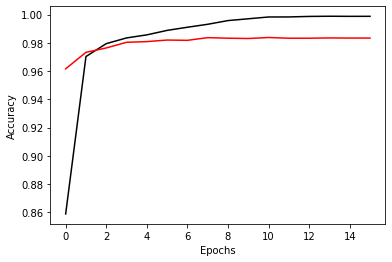

In [12]:
# Load a model

model_loc = "/glade/work/schreck/repos/HOLO/holodec-ml/holodecml/reader/models/resnet18_initial"

f = pd.read_csv(f"{model_loc}/training_log.csv")
plt.plot(f["epoch"], f["train_accuracy"], c = 'k')
plt.plot(f["epoch"], f["valid_accuracy"], c = 'r')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

fcl_layers = []
dropout = 0.2
output_size = 2
resnet_model = 18
pretrained = True

model = ResNet(fcl_layers, 
               dr = dropout, 
               output_size = output_size, 
               resnet_model=resnet_model, 
               pretrained = pretrained).to(device)


checkpoint = torch.load(
    f"{model_loc}/best.pt",
    map_location=lambda storage, loc: storage
)
model.load_state_dict(checkpoint["model_state_dict"])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"There are {total_params} total model parameters")


In [13]:
#model.share_memory()

prop = InferencePropagator(
    synthetic_path, 
    n_bins = n_bins,
    tile_size = tile_size,
    step_size = step_size,
    marker_size = marker_size,
    model = model,
    device = device
)


In [14]:
h_idx = 10
test_image = prop.h_ds['image'].isel(hologram_number=h_idx)


In [15]:
sx = test_image.shape[0] // step_size
sy = test_image.shape[1] // step_size


In [16]:
x, y, z = [], [], []
xt, yt, zt = [], [], []

max_planes = 1000

ncpus = 8
with mp.Pool(ncpus) as p:
    
    for results in tqdm.tqdm(p.imap(process_one_plane, z_file_indices[:max_planes]), total = max_planes):
        
        x += results["preds"][0]
        y += results["preds"][1]
        z += results["preds"][2]

        xt += results["truths"][0]
        yt += results["truths"][1]
        zt += results["truths"][2]

100%|██████████| 1000/1000 [07:07<00:00,  2.34it/s]


(14072.0, 157928.0)

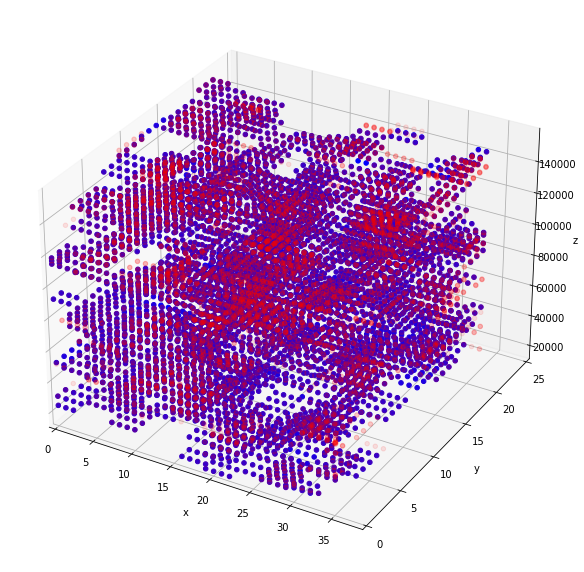

In [17]:
fig = plt.figure(figsize = (10, 20))
ax = plt.axes(projection ="3d")

ax.scatter3D(x, y, z, c = "r", alpha = 0.1, zorder = 1, marker = 'o') 
ax.scatter3D(xt, yt, zt, c = 'b', alpha = 1.0, zorder = 2, marker = 'o')

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim([0, sx])
ax.set_ylim([0, sy])
ax.set_zlim([z_file_indices[0], z_file_indices[max_planes-1]])


Interactive bokeh example: https://github.com/bokeh/bokeh/blob/2.3.3/examples/howto/notebook_comms/Jupyter%20Interactors.ipynb

In [18]:
from ipywidgets import interact

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure

from bokeh.palettes import colorblind

output_notebook()


Loading BokehJS ...

In [19]:
df_pred = pd.DataFrame({'x':x, 'y':y, 'z':z})
df_true = pd.DataFrame({'x':xt, 'y':yt, 'z':zt})
z_plane_options = np.unique(df_pred['z'].values)


In [20]:
p = figure(title=f"Particles per z-plane {z_plane_options[0]}",
           plot_height=300,
           plot_width=600,
           x_range=(0, sx),
           y_range=(0, sy))
pred = p.scatter(df_pred.loc[df_pred['z'] == z_plane_options[0], 'x'],
                 df_pred.loc[df_pred['z'] == z_plane_options[0], 'y'],
                 fill_color='#0072B2',
                 line_alpha=0.0,
#                  fill_alpha=0.6,
                 size=10,
                 legend_label="Predicted")
true = p.scatter(df_true.loc[df_true['z'] == z_plane_options[0], 'x'],
                 df_true.loc[df_true['z'] == z_plane_options[0], 'y'],
                 fill_color='#E69F00',
                 line_alpha=0.0,
#                  fill_alpha=0.6,
                 size=7,
                 legend_label="True")
p.legend.click_policy="hide"


In [21]:
def update(z_plane):
    pred.data_source.data['x'] = df_pred.loc[df_pred['z'] == z_plane, 'x']
    pred.data_source.data['y'] = df_pred.loc[df_pred['z'] == z_plane, 'y']
    true.data_source.data['x'] = df_true.loc[df_true['z'] == z_plane, 'x']
    true.data_source.data['y'] = df_true.loc[df_true['z'] == z_plane, 'y']
    p.title = f"Particles per z-plane {z_plane}"
    push_notebook()
    

In [22]:
show(p, notebook_handle=True)

In [23]:
interact(update, z_plane=z_plane_options)

interactive(children=(Dropdown(description='z_plane', options=(14072, 14216, 14360, 14504, 15512, 15656, 15944…

<function __main__.update>

In [24]:
import plotly.express as px


In [25]:
df_true["true"] = "True"
df_pred["true"] = "Predicted"

In [26]:
df = pd.concat((df_pred, df_true))

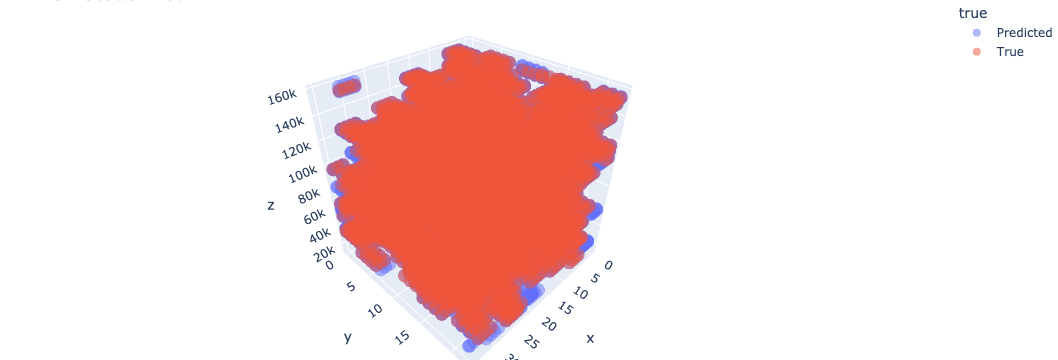

In [28]:
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    color='true', opacity=0.5,
                    title="3D Scatter Plot")
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()
